In [1]:
from sys import path
import numpy as np
import os
import pandas as pd
from datetime import datetime as dt
import json
import warnings
warnings.filterwarnings("ignore")
from copy import deepcopy
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
root_dir = "./"
input_dir = root_dir + "input_data"
output_dir = root_dir + "sample_result_submission"
program_dir = root_dir + "ingestion_program"
submission_dir = root_dir + "sample_code_submission"

path.append(input_dir)
path.append(output_dir)
path.append(program_dir)
path.append(submission_dir)



In [3]:
from systematics import Systematics

In [4]:
from model import Model

In [5]:
class Ingestion():

    def __init__(self, test_dir="test", use_systematics=True, original_weights=False, reweight=True, balance=False):

        self.test_dir = test_dir
        self.use_systematics = use_systematics
        self.original_weights = original_weights
        self.reweight = reweight
        self.balance = balance

        # Initialize class variables
        self.model = None
        self.train_set = None
        self.test_sets = []


    def load_train_set(self):
        print("[*] Loading Train data")

        train_data_file = os.path.join(input_dir, 'train', 'data', 'data.csv')
        train_labels_file = os.path.join(input_dir, 'train', 'labels', "data.labels")
        train_settings_file = os.path.join(input_dir, 'train', 'settings', "data.json")

        # read train data
        train_data = pd.read_csv(train_data_file)


        # read trian labels
        with open(train_labels_file, "r") as f:
            train_labels = np.array(f.read().splitlines(), dtype=float)

        train_data["Label"] = train_labels


        # balance classes in train dataframe
        if self.balance:
            singal_df = train_data[train_data["Label"] == 1]
            background_df = train_data[train_data["Label"] == 0]

            if len(singal_df) > len(background_df):
                singal_df = singal_df.sample(len(background_df))
            else:
                background_df = background_df.sample(len(singal_df))

            combined_df = pd.concat([singal_df, background_df])
            combined_df = combined_df.sample(frac=1).reset_index(drop=True)

            train_data = combined_df
            train_labels = combined_df["Label"]
            train_data = train_data.drop("Label", axis=1)

        if self.reweight:
            # # ------
            # # Train weights adjustment
            # # ------
            weights_train = deepcopy(train_data["Weight"])
            class_weights_train = (weights_train[train_labels == 0].sum(), weights_train[train_labels == 1].sum())

            for i in range(len(class_weights_train)): # loop on B then S target
                #training dataset: equalize number of background and signal
                weights_train[train_labels == i] *= max(class_weights_train)/ class_weights_train[i] 

            # reassign weight to data
            if self.original_weights:
                train_data["New_Weight"] = train_data["Weight"]
               
            else:
                train_data["New_Weight"] = weights_train
                train_data["Weight"] = weights_train
                
            # ------
        else:
            train_data["New_Weight"] = np.repeat(1, len(train_data))
            train_data["Weight"] =  np.repeat(1, len(train_data))

        print("Bg Labels: ", np.sum(train_labels==0))
        print("Sig Labels: ", np.sum(train_labels==1))
        print("Bg weights: ", train_data[train_labels == 0]["New_Weight"].sum())
        print("Sig weights: ", train_data[train_labels == 1]["New_Weight"].sum())
        

        # read train settings
        with open(train_settings_file) as f:
            train_settings = json.load(f)

        self.train_set = {
            "data": train_data,
            "labels": train_labels,
            "settings": train_settings
        }

    def load_test_sets(self):
        print("[*] Loading Test data")
        self.test_sets = []
        for i in range(0, 10):
            test_data_file = os.path.join(input_dir, self.test_dir, 'data', 'data_'+str(i)+'.csv')
            self.test_sets.append(pd.read_csv(test_data_file))

    def initialize_submission(self):
        print("[*] Initializing submitted model")
        self.model = Model(
            train_set=self.train_set,
            test_sets=self.test_sets,
            systematics=Systematics,
            use_systematics=self.use_systematics
        )

    def fit_submission(self):
        print("[*] Calling fit method of submitted model")
        self.model.fit()

    def predict_submission(self):
        print("[*] Calling predict method of submitted model")
        predicted_dict = self.model.predict()

        self.mu_hats = predicted_dict["mu_hats"]
        self.delta_mu_hat = predicted_dict["delta_mu_hat"]
        self.test_sets_decisions = predicted_dict["decisions"]
        self.test_sets_predictions = predicted_dict["predictions"]
        self.best_theta = predicted_dict["theta"]

    def get_mu_delta_hat(self):
        return self.mu_hats, self.delta_mu_hat

    def save_result(self):

        print("[*] Saving result")

        result_dict = {
            "delta_mu_hat": self.delta_mu_hat,
            "mu_hats": self.mu_hats
        }
        print(f"[*] --- delta_mu_hat: {result_dict['delta_mu_hat']}")
        print(f"[*] --- mu_hats (avg): {np.mean(result_dict['mu_hats'])}")

        result_file = os.path.join(output_dir, "result.json")

        with open(result_file, 'w') as f:
            f.write(json.dumps(result_dict, indent=4))

    def plot_pair(self):
        sns.pairplot(self.train_set["data"])
        

    def plot_decisions(self):

        num_rows = 2

        fig, axes = plt.subplots(num_rows, 5, figsize=(15, num_rows * 3))  # Create subplots
        axes = axes.flatten()
        for i, (decisions, predictions) in enumerate(zip(self.test_sets_decisions, self.test_sets_predictions)):
            
            ax = axes[i]  # Handle single-row case

            ax.hist([decisions[predictions == 0], decisions[predictions == 1]], alpha=0.5, color=['blue', 'red'], label=['Background', 'Signal'])
            ax.set_xlabel('Decisions')
            ax.set_ylabel('Frequency')
            ax.set_title(f'Test Set {i + 1} Decisions Histogram')
            ax.legend()

        plt.tight_layout()
        plt.show()

    def plot_weights(self):

        num_rows = 2

        fig, axes = plt.subplots(num_rows, 5, figsize=(15, num_rows * 3))  # Create subplots
        axes = axes.flatten()
        for i, (test_prediction, test_set) in enumerate(zip(self.test_sets_predictions, self.test_sets)):
            
            ax = axes[i]  # Handle single-row case
            weights_col = test_set["Weight"]
            signal_indexes = test_prediction == 1
            background_indexes = test_prediction == 0

            signal_weights = weights_col[signal_indexes].sum()
            background_weights = weights_col[background_indexes].sum()
            
            ax.bar("Signal", signal_weights, label="Signal")
            ax.bar("Background", background_weights, label="Background")
            ax.set_yscale("log")
            ax.set_xlabel('Labels')
            ax.set_ylabel('Sum of Weight')
            ax.set_title(f'Test Set {i + 1} Sum of Weights')
            ax.legend()

        plt.tight_layout()
        plt.show()


    def do_all(self):
        # load test set
        self.load_train_set()

        # load test set
        self.load_test_sets()

        # Initialize submission
        self.initialize_submission()

        # Call fit method of submission
        self.fit_submission()

        # Call predict method of submission
        self.predict_submission()

        # decision function plot
        self.plot_decisions()



### Experiment
- Unbalanced classes  + Original weights
- Balanced classes  + Original weights
- Unbalanced classes  +  weights = 1
- Balanced classes  +  weights = 1

In [25]:
def plot_mu_delta_mu(mus_delta_mus_list, weights_title="Org"):
    labels = [
        "Balance: NO , Weight: "+weights_title,
        "Balance: YES , Weight: "+weights_title,
        "Balance: NO , Weight: 1",
        "Balance: YES , Weight: 1"
    ]
    markers = ['o', 's', '^', 'd']
    colors = ['red', 'blue', 'green', 'purple']
    ground_truth_mus = [1.050,1.055, 1.060, 1.065]

    for i, (mus, delta_mu_hat) in enumerate(mus_delta_mus_list):
    
        x = ground_truth_mus[i]
        y = np.mean(mus)

        plt.scatter(x, y, label=labels[i], color=colors[i], marker=markers[i], alpha=0.5)


    # Add labels to the axes
    plt.xlabel('Ground Truth Mu')
    plt.ylabel('Predicted Mu')
    plt.xlim(0.9,1.1)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=4)
    plt.show()
    

In [7]:
ingestion1 = Ingestion(test_dir="test_no_sys", use_systematics=False, original_weights=True, reweight=True, balance=False)
ingestion2 = Ingestion(test_dir="test_no_sys_balanced", use_systematics=False, original_weights=True, reweight=True, balance=True)
ingestion3 = Ingestion(test_dir="test_no_sys", use_systematics=False, original_weights=True, reweight=False, balance=False)
ingestion4 = Ingestion(test_dir="test_no_sys_balanced", use_systematics=False, original_weights=True, reweight=False, balance=True)


### 

[*] Loading Train data
Bg Labels:  49992
Sig Labels:  119062
Bg weights:  2002831.1513999999
Sig weights:  6765.775725474
[*] Loading Test data
[*] Initializing submitted model
[*] Calling fit method of submitted model
[*] - Generating Validation sets
[*] - Train a classifier
[*] --- Loading Model
[*] --- Training Model
[*] --- Predicting Train set
[*] Choose best theta
[*] --- Best theta : -7
[*] - Computing Validation result
[*] --- mu: 1.0 --- mu_hat: 0.997 --- delta_mu_hat: 0.003
[*] --- mu: 1.0 --- mu_hat: 0.997 --- delta_mu_hat: 0.003
[*] --- mu: 1.0 --- mu_hat: 0.997 --- delta_mu_hat: 0.003
[*] --- mu: 1.0 --- mu_hat: 0.997 --- delta_mu_hat: 0.003
[*] --- mu: 1.0 --- mu_hat: 0.997 --- delta_mu_hat: 0.003
[*] --- mu: 1.0 --- mu_hat: 0.997 --- delta_mu_hat: 0.003
[*] --- mu: 1.0 --- mu_hat: 0.997 --- delta_mu_hat: 0.003
[*] --- mu: 1.0 --- mu_hat: 0.997 --- delta_mu_hat: 0.003
[*] --- mu: 1.0 --- mu_hat: 0.997 --- delta_mu_hat: 0.003
[*] --- mu: 1.0 --- mu_hat: 0.997 --- delta_mu_

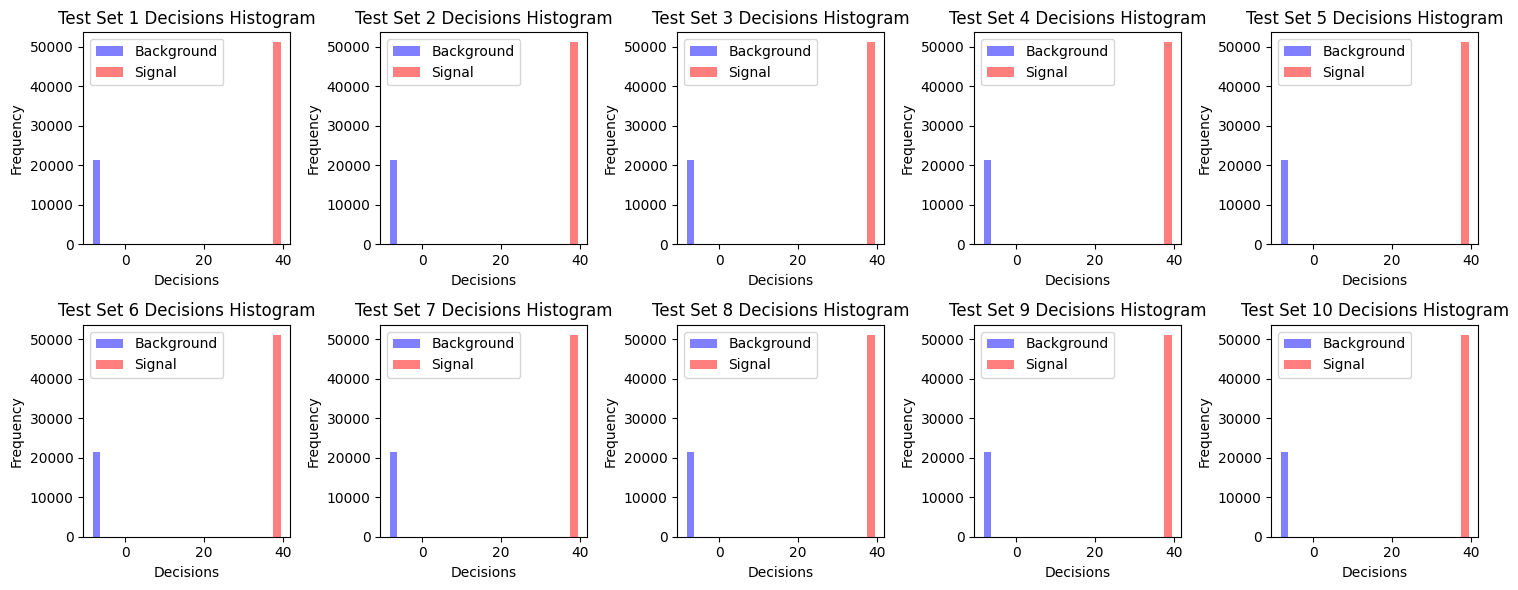

In [8]:
ingestion1.do_all()

[*] Loading Train data
Bg Labels:  49992
Sig Labels:  49992
Bg weights:  2002831.1514000003
Sig weights:  2841.01847997
[*] Loading Test data
[*] Initializing submitted model
[*] Calling fit method of submitted model
[*] - Generating Validation sets
[*] - Train a classifier
[*] --- Loading Model
[*] --- Training Model
[*] --- Predicting Train set
[*] Choose best theta
[*] --- Best theta : -8
[*] - Computing Validation result
[*] --- mu: 1.0 --- mu_hat: 0.998 --- delta_mu_hat: 0.002
[*] --- mu: 1.0 --- mu_hat: 0.998 --- delta_mu_hat: 0.002
[*] --- mu: 1.0 --- mu_hat: 0.998 --- delta_mu_hat: 0.002
[*] --- mu: 1.0 --- mu_hat: 0.998 --- delta_mu_hat: 0.002
[*] --- mu: 1.0 --- mu_hat: 0.998 --- delta_mu_hat: 0.002
[*] --- mu: 1.0 --- mu_hat: 0.998 --- delta_mu_hat: 0.002
[*] --- mu: 1.0 --- mu_hat: 0.998 --- delta_mu_hat: 0.002
[*] --- mu: 1.0 --- mu_hat: 0.998 --- delta_mu_hat: 0.002
[*] --- mu: 1.0 --- mu_hat: 0.998 --- delta_mu_hat: 0.002
[*] --- mu: 1.0 --- mu_hat: 0.998 --- delta_mu_ha

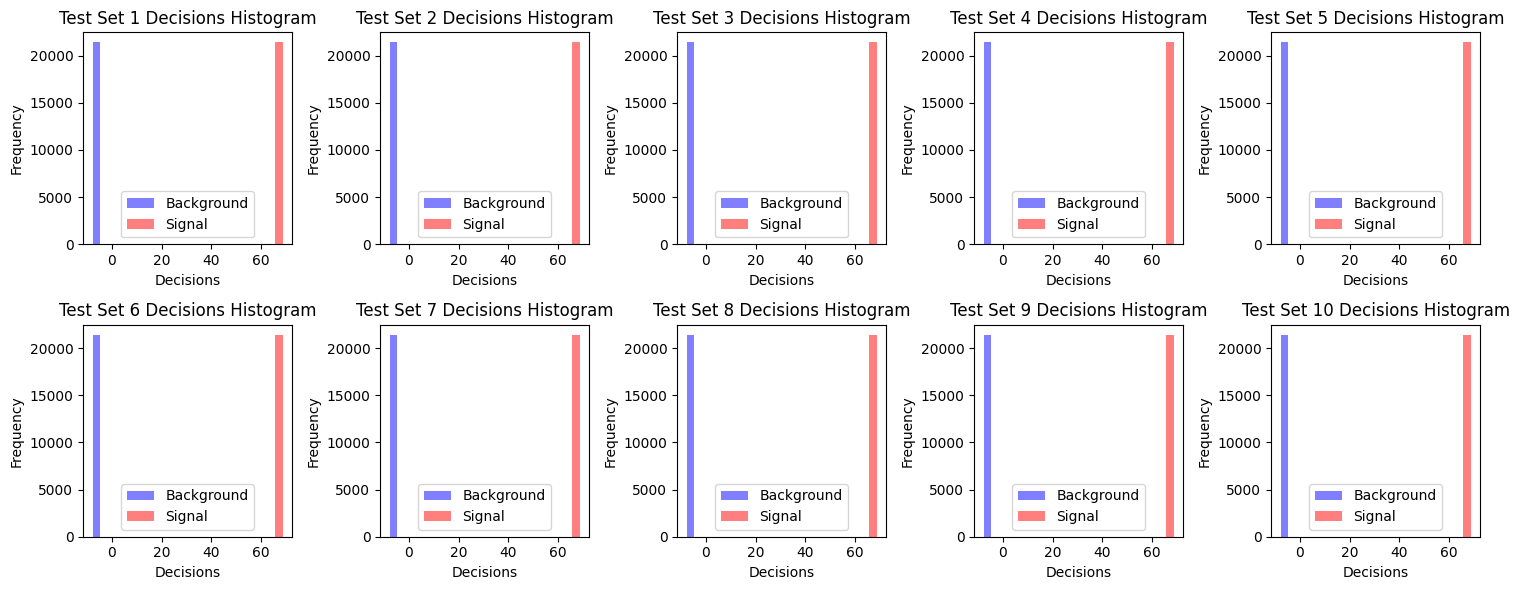

In [9]:
ingestion2.do_all()

[*] Loading Train data
Bg Labels:  49992
Sig Labels:  119062
Bg weights:  49992
Sig weights:  119062
[*] Loading Test data
[*] Initializing submitted model
[*] Calling fit method of submitted model
[*] - Generating Validation sets
[*] - Train a classifier
[*] --- Loading Model
[*] --- Training Model
[*] --- Predicting Train set
[*] Choose best theta
[*] --- Best theta : -5
[*] - Computing Validation result
[*] --- mu: 1.0 --- mu_hat: 0.429 --- delta_mu_hat: 0.571
[*] --- mu: 1.0 --- mu_hat: 0.429 --- delta_mu_hat: 0.571
[*] --- mu: 1.0 --- mu_hat: 0.429 --- delta_mu_hat: 0.571
[*] --- mu: 1.0 --- mu_hat: 0.429 --- delta_mu_hat: 0.571
[*] --- mu: 1.0 --- mu_hat: 0.429 --- delta_mu_hat: 0.571
[*] --- mu: 1.0 --- mu_hat: 0.429 --- delta_mu_hat: 0.571
[*] --- mu: 1.0 --- mu_hat: 0.429 --- delta_mu_hat: 0.571
[*] --- mu: 1.0 --- mu_hat: 0.429 --- delta_mu_hat: 0.571
[*] --- mu: 1.0 --- mu_hat: 0.429 --- delta_mu_hat: 0.571
[*] --- mu: 1.0 --- mu_hat: 0.429 --- delta_mu_hat: 0.571
[*] --- de

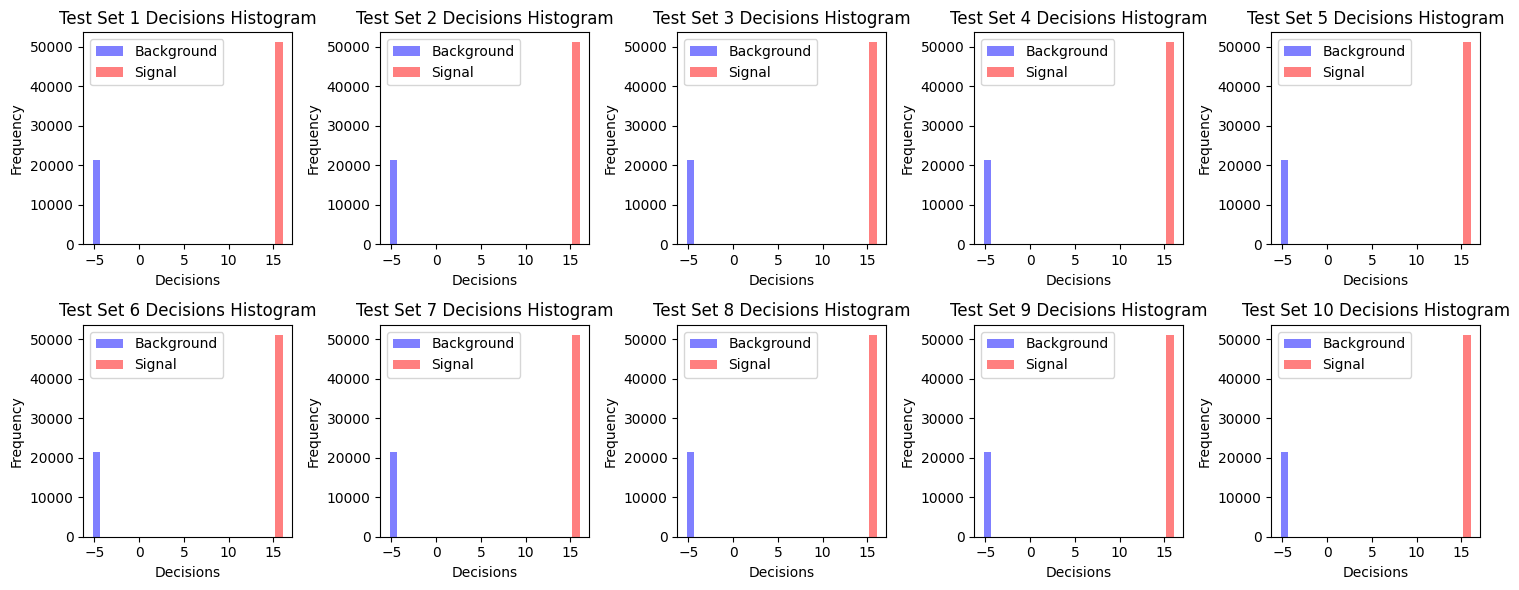

In [10]:
ingestion3.do_all()

[*] Loading Train data
Bg Labels:  49992
Sig Labels:  49992
Bg weights:  49992
Sig weights:  49992
[*] Loading Test data
[*] Initializing submitted model
[*] Calling fit method of submitted model
[*] - Generating Validation sets
[*] - Train a classifier
[*] --- Loading Model
[*] --- Training Model
[*] --- Predicting Train set
[*] Choose best theta
[*] --- Best theta : -5
[*] - Computing Validation result
[*] --- mu: 1.0 --- mu_hat: 0.426 --- delta_mu_hat: 0.574
[*] --- mu: 1.0 --- mu_hat: 0.426 --- delta_mu_hat: 0.574
[*] --- mu: 1.0 --- mu_hat: 0.426 --- delta_mu_hat: 0.574
[*] --- mu: 1.0 --- mu_hat: 0.426 --- delta_mu_hat: 0.574
[*] --- mu: 1.0 --- mu_hat: 0.426 --- delta_mu_hat: 0.574
[*] --- mu: 1.0 --- mu_hat: 0.426 --- delta_mu_hat: 0.574
[*] --- mu: 1.0 --- mu_hat: 0.426 --- delta_mu_hat: 0.574
[*] --- mu: 1.0 --- mu_hat: 0.426 --- delta_mu_hat: 0.574
[*] --- mu: 1.0 --- mu_hat: 0.426 --- delta_mu_hat: 0.574
[*] --- mu: 1.0 --- mu_hat: 0.426 --- delta_mu_hat: 0.574
[*] --- delt

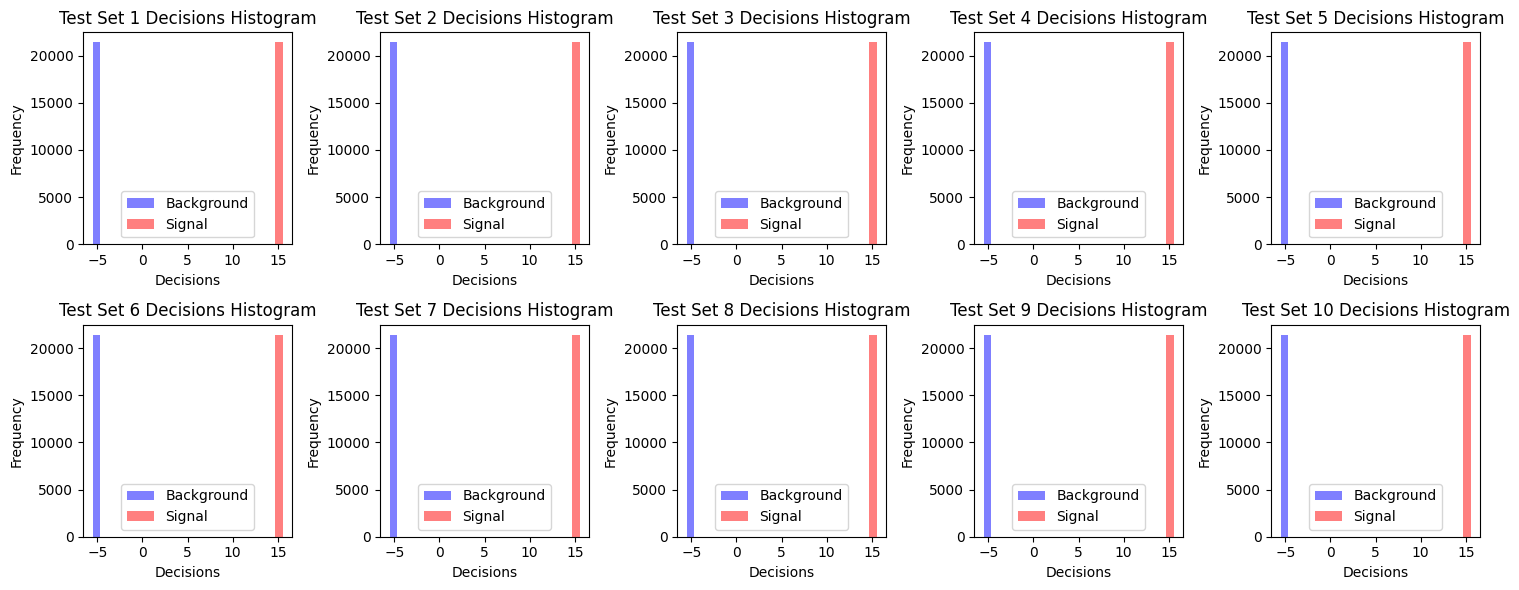

In [11]:
ingestion4.do_all()

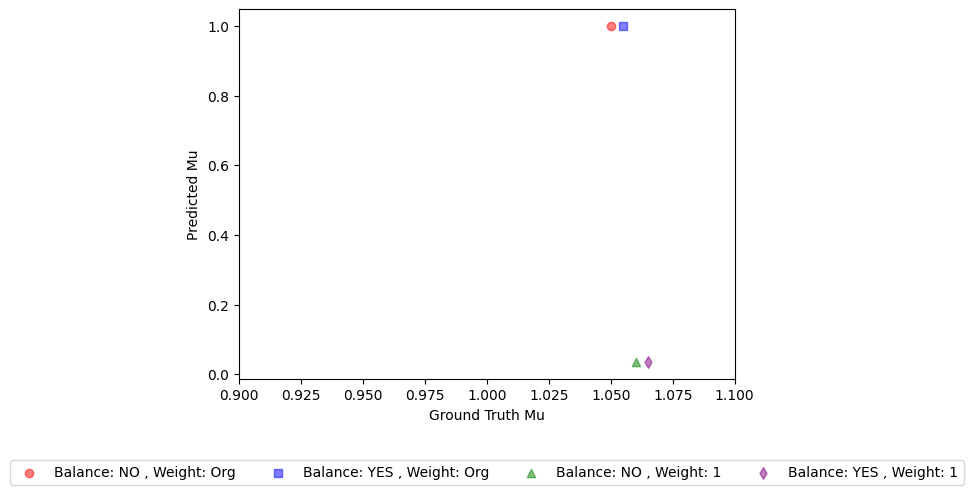

In [26]:
mus_delta_mus_list = [
    ingestion1.get_mu_delta_hat(),
    ingestion2.get_mu_delta_hat(),
    ingestion3.get_mu_delta_hat(),
    ingestion4.get_mu_delta_hat(),
]

plot_mu_delta_mu(mus_delta_mus_list, "Org")

## Reweight

In [13]:
ingestion5 = Ingestion(test_dir="test_no_sys", use_systematics=False, original_weights=False, reweight=True, balance=False)
ingestion6 = Ingestion(test_dir="test_no_sys_balanced", use_systematics=False, original_weights=False, reweight=True, balance=True)
ingestion7 = Ingestion(test_dir="test_no_sys", use_systematics=False, original_weights=False, reweight=False, balance=False)
ingestion8 = Ingestion(test_dir="test_no_sys_balanced", use_systematics=False, original_weights=False, reweight=False, balance=True)


[*] Loading Train data
Bg Labels:  49992
Sig Labels:  119062
Bg weights:  2002831.1513999999
Sig weights:  2002831.1513999994
[*] Loading Test data
[*] Initializing submitted model
[*] Calling fit method of submitted model
[*] - Generating Validation sets
[*] - Train a classifier
[*] --- Loading Model
[*] --- Training Model
[*] --- Predicting Train set
[*] Choose best theta
[*] --- Best theta : -5
[*] - Computing Validation result
[*] --- mu: 1.0 --- mu_hat: 0.592 --- delta_mu_hat: 0.408
[*] --- mu: 1.0 --- mu_hat: 0.592 --- delta_mu_hat: 0.408
[*] --- mu: 1.0 --- mu_hat: 0.592 --- delta_mu_hat: 0.408
[*] --- mu: 1.0 --- mu_hat: 0.592 --- delta_mu_hat: 0.408
[*] --- mu: 1.0 --- mu_hat: 0.592 --- delta_mu_hat: 0.408
[*] --- mu: 1.0 --- mu_hat: 0.592 --- delta_mu_hat: 0.408
[*] --- mu: 1.0 --- mu_hat: 0.592 --- delta_mu_hat: 0.408
[*] --- mu: 1.0 --- mu_hat: 0.592 --- delta_mu_hat: 0.408
[*] --- mu: 1.0 --- mu_hat: 0.592 --- delta_mu_hat: 0.408
[*] --- mu: 1.0 --- mu_hat: 0.592 --- delta

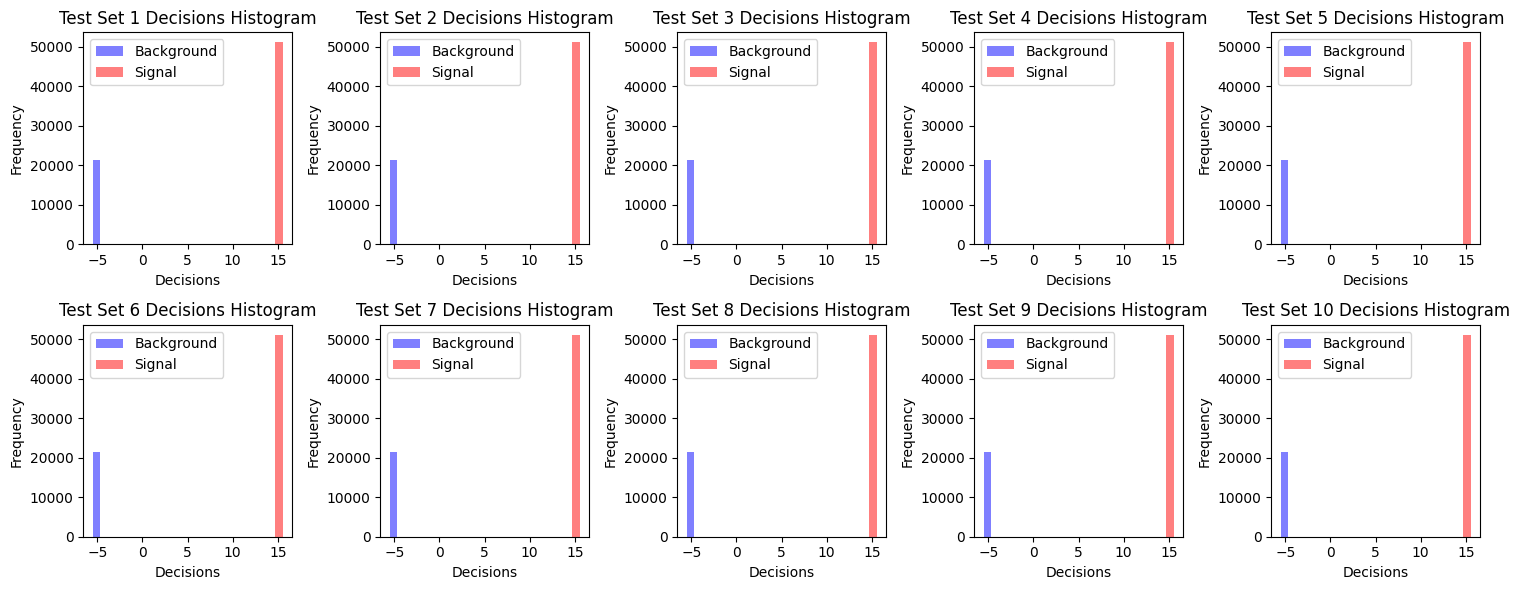

In [14]:
ingestion5.do_all()

[*] Loading Train data
Bg Labels:  49992
Sig Labels:  49992
Bg weights:  2002831.1514
Sig weights:  2002831.1513999996
[*] Loading Test data
[*] Initializing submitted model
[*] Calling fit method of submitted model
[*] - Generating Validation sets
[*] - Train a classifier
[*] --- Loading Model
[*] --- Training Model
[*] --- Predicting Train set
[*] Choose best theta
[*] --- Best theta : -5
[*] - Computing Validation result
[*] --- mu: 1.0 --- mu_hat: 0.426 --- delta_mu_hat: 0.574
[*] --- mu: 1.0 --- mu_hat: 0.426 --- delta_mu_hat: 0.574
[*] --- mu: 1.0 --- mu_hat: 0.426 --- delta_mu_hat: 0.574
[*] --- mu: 1.0 --- mu_hat: 0.426 --- delta_mu_hat: 0.574
[*] --- mu: 1.0 --- mu_hat: 0.426 --- delta_mu_hat: 0.574
[*] --- mu: 1.0 --- mu_hat: 0.426 --- delta_mu_hat: 0.574
[*] --- mu: 1.0 --- mu_hat: 0.426 --- delta_mu_hat: 0.574
[*] --- mu: 1.0 --- mu_hat: 0.426 --- delta_mu_hat: 0.574
[*] --- mu: 1.0 --- mu_hat: 0.426 --- delta_mu_hat: 0.574
[*] --- mu: 1.0 --- mu_hat: 0.426 --- delta_mu_hat

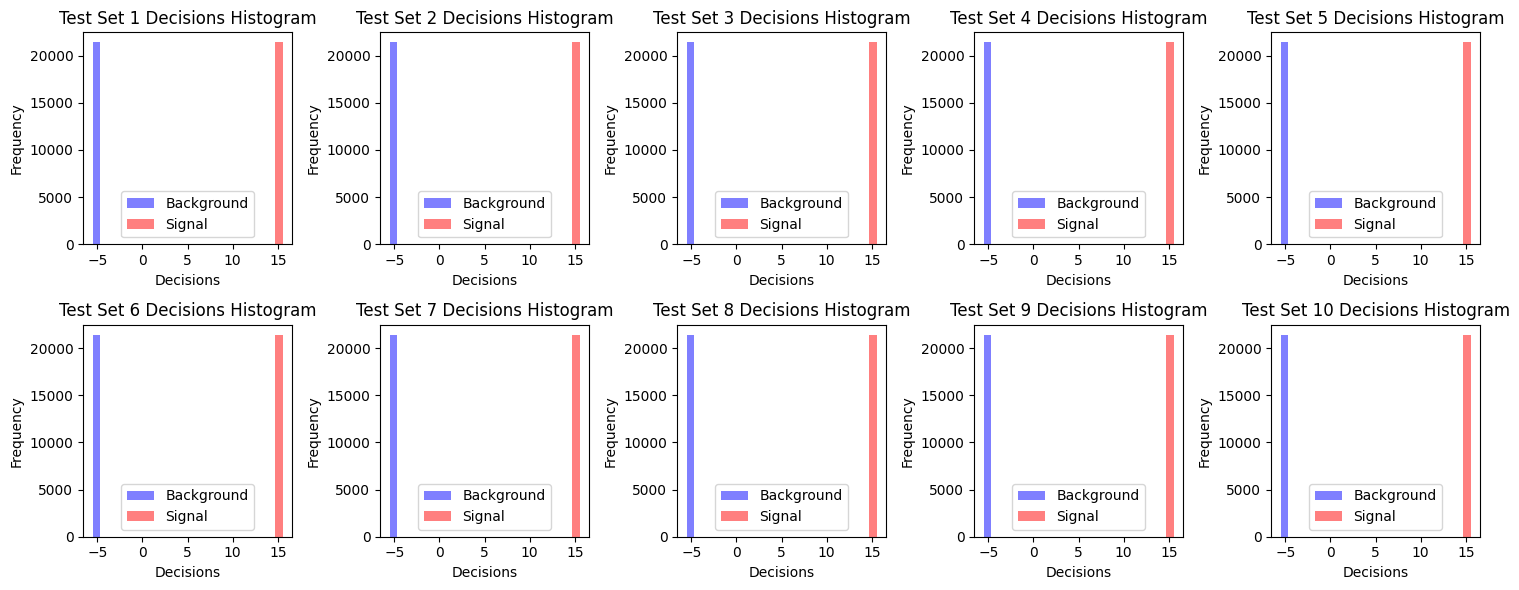

In [15]:
ingestion6.do_all()

[*] Loading Train data
Bg Labels:  49992
Sig Labels:  119062
Bg weights:  49992
Sig weights:  119062
[*] Loading Test data
[*] Initializing submitted model
[*] Calling fit method of submitted model
[*] - Generating Validation sets
[*] - Train a classifier
[*] --- Loading Model
[*] --- Training Model
[*] --- Predicting Train set
[*] Choose best theta
[*] --- Best theta : -5
[*] - Computing Validation result
[*] --- mu: 1.0 --- mu_hat: 0.429 --- delta_mu_hat: 0.571
[*] --- mu: 1.0 --- mu_hat: 0.429 --- delta_mu_hat: 0.571
[*] --- mu: 1.0 --- mu_hat: 0.429 --- delta_mu_hat: 0.571
[*] --- mu: 1.0 --- mu_hat: 0.429 --- delta_mu_hat: 0.571
[*] --- mu: 1.0 --- mu_hat: 0.429 --- delta_mu_hat: 0.571
[*] --- mu: 1.0 --- mu_hat: 0.429 --- delta_mu_hat: 0.571
[*] --- mu: 1.0 --- mu_hat: 0.429 --- delta_mu_hat: 0.571
[*] --- mu: 1.0 --- mu_hat: 0.429 --- delta_mu_hat: 0.571
[*] --- mu: 1.0 --- mu_hat: 0.429 --- delta_mu_hat: 0.571
[*] --- mu: 1.0 --- mu_hat: 0.429 --- delta_mu_hat: 0.571
[*] --- de

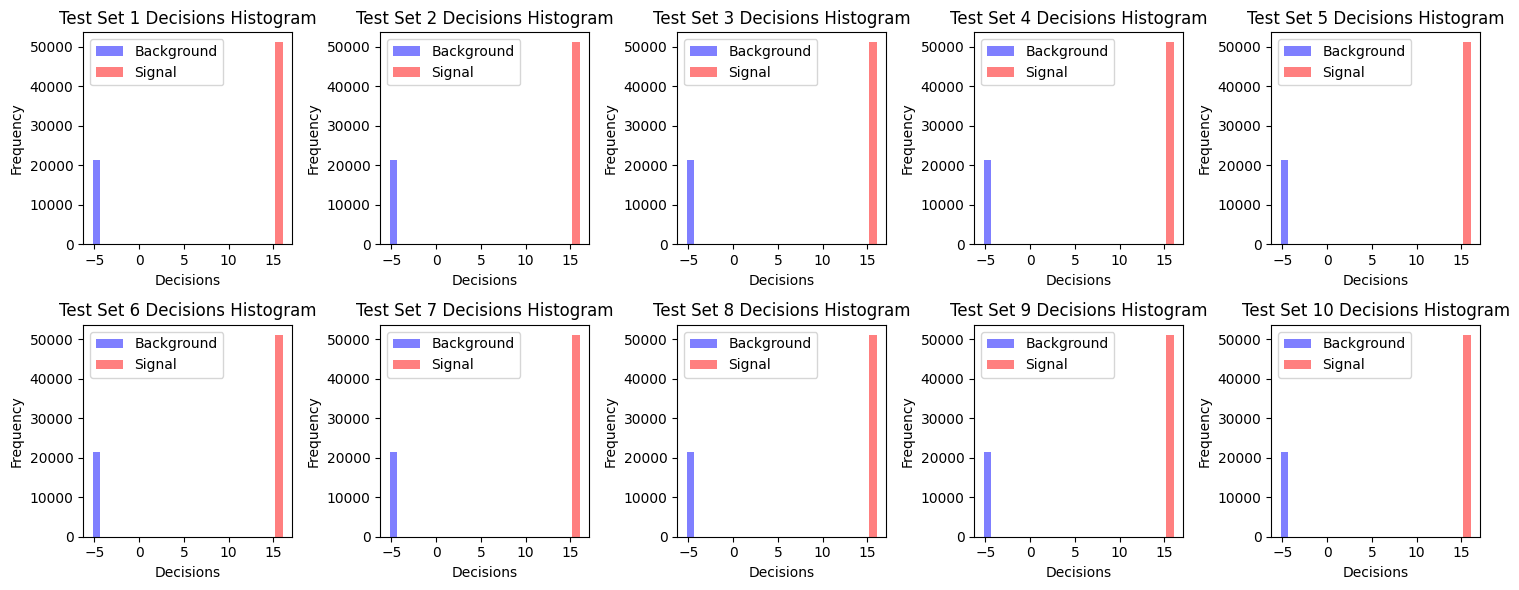

In [16]:
ingestion7.do_all()

[*] Loading Train data
Bg Labels:  49992
Sig Labels:  49992
Bg weights:  49992
Sig weights:  49992
[*] Loading Test data
[*] Initializing submitted model
[*] Calling fit method of submitted model
[*] - Generating Validation sets
[*] - Train a classifier
[*] --- Loading Model
[*] --- Training Model
[*] --- Predicting Train set
[*] Choose best theta
[*] --- Best theta : -5
[*] - Computing Validation result
[*] --- mu: 1.0 --- mu_hat: 0.428 --- delta_mu_hat: 0.572
[*] --- mu: 1.0 --- mu_hat: 0.428 --- delta_mu_hat: 0.572
[*] --- mu: 1.0 --- mu_hat: 0.428 --- delta_mu_hat: 0.572
[*] --- mu: 1.0 --- mu_hat: 0.428 --- delta_mu_hat: 0.572
[*] --- mu: 1.0 --- mu_hat: 0.428 --- delta_mu_hat: 0.572
[*] --- mu: 1.0 --- mu_hat: 0.428 --- delta_mu_hat: 0.572
[*] --- mu: 1.0 --- mu_hat: 0.428 --- delta_mu_hat: 0.572
[*] --- mu: 1.0 --- mu_hat: 0.428 --- delta_mu_hat: 0.572
[*] --- mu: 1.0 --- mu_hat: 0.428 --- delta_mu_hat: 0.572
[*] --- mu: 1.0 --- mu_hat: 0.428 --- delta_mu_hat: 0.572
[*] --- delt

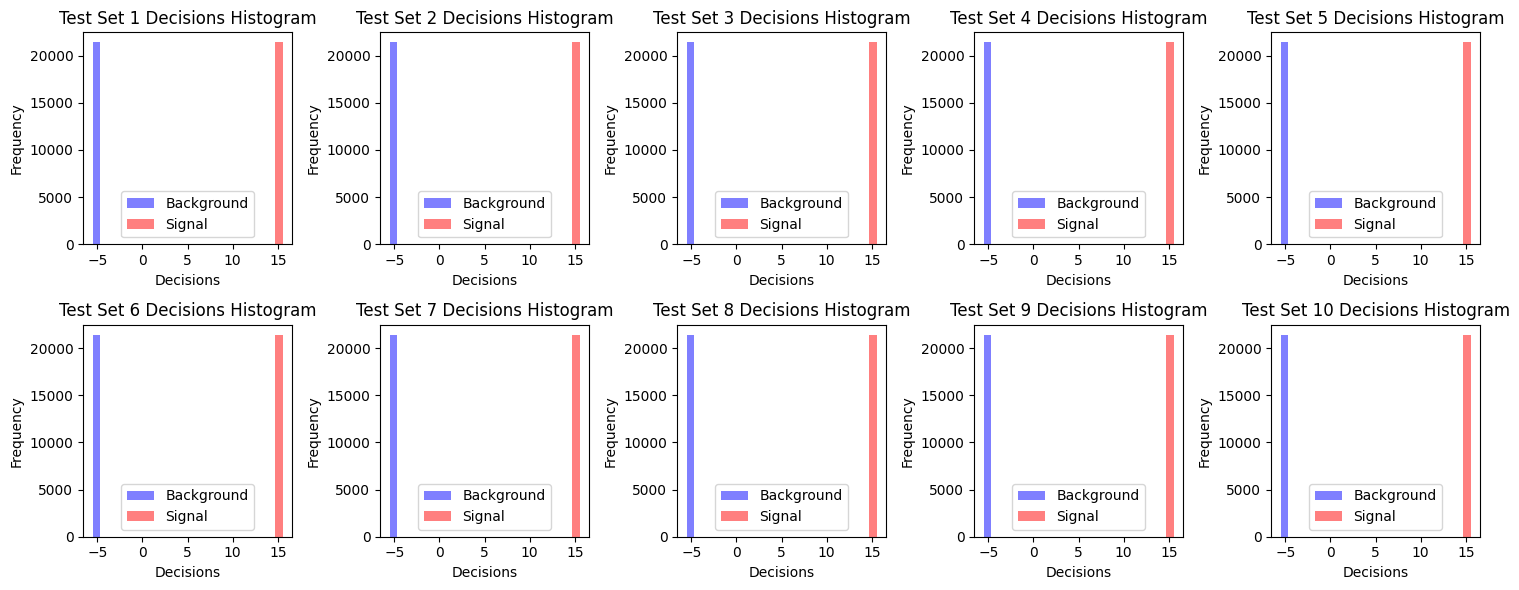

In [17]:
ingestion8.do_all()

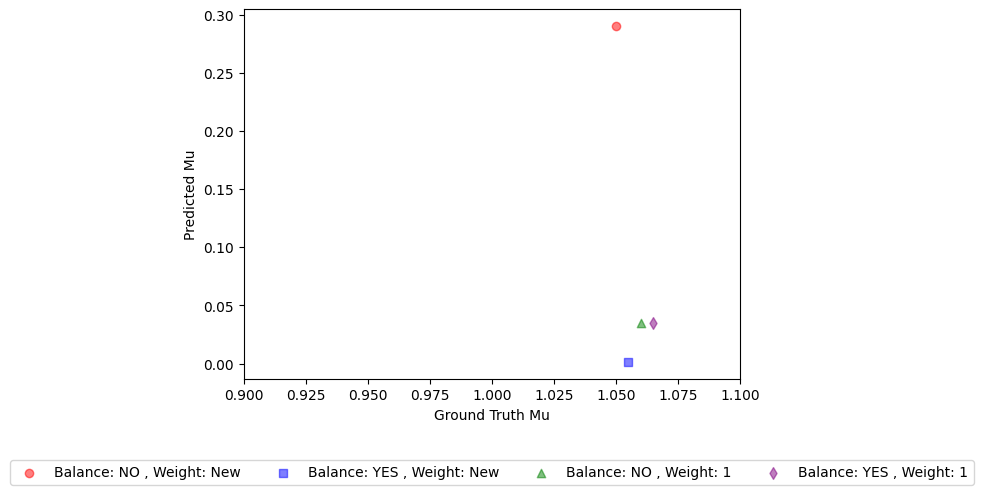

In [27]:
mus_delta_mus_list = [
    ingestion5.get_mu_delta_hat(),
    ingestion6.get_mu_delta_hat(),
    ingestion7.get_mu_delta_hat(),
    ingestion8.get_mu_delta_hat(),
]

plot_mu_delta_mu(mus_delta_mus_list, "New")